# Time-Series Forecasting | Corporación Favorita Grocery Sales
## Section 2: Exploratory Data Analysis
### 1 - Notebook Overview

The goal of this notebook is to conduct an exploratory analysis of the **Pichincha** sample dataset extracted in [Section 1: Data Preparation](/notebooks/01-data-preparation.ipynb) and uncover the underlying patterns of grocery sales in Ecuador. Specifically, this notebook will:

- **Trend & Seasonality Visualization:** Using total sales line plots and Year-Month heatmaps to identify growth trends, December peaks, and period-specific anomalies.
- **Holiday & Event Impact:** Quantifying the "lift" or "suppression" of demand by merging the holiday calendar and analyzing average sales by day-type.
- **Perishability & Category Dynamics:** Segmenting sales between perishable and non-perishable items to assess volume shares and waste risk—a critical factor for forecast accuracy.
- **Macroeconomic Sensitivity (Oil Prices):** Evaluating the relationship between global oil price fluctuations and local retail demand using rolling Pearson correlation to determine if macroeconomic shocks provide a predictive signal or simply introduce noise.
- **Time-Series Diagnostics:**
  - **Autocorrelation:** Identifying how past sales influence future values to inform "lag" feature selection.
  - **Stationarity:** Testing the data's statistical properties to determine if differencing is required for modeling.

By the end of this analysis, we will have a "signal-ready" dataset and a clear understanding of the external factors (holidays, oil prices) that must be incorporated into the forecasting models in Section 3.

### 2 - Import Libraries

In [32]:
# Core libraries
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# File handling
import os

# Statistical analysis
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

### 3 - Data Ingestion

In [2]:
# Define local paths to data files
holidays_path = "../data/holidays_events.csv"
items_path = "../data/items.csv"
oil_path = "../data/oil.csv"
stores_path = "../data/stores.csv"
train_path = "../data/train_sample.pkl"
transactions_path = "../data/transactions.csv"

# List of all paths to verify
required_paths = [
    holidays_path, 
    items_path, 
    oil_path, 
    stores_path, 
    train_path,
    transactions_path
]

# Create a list to track any missing files
missing_files = []

for path in required_paths:
    if not os.path.exists(path):
        missing_files.append(path)

if missing_files:
    print("❌ ERROR: Required data files not found in the /data/ folder.")
    print("-" * 50)
    for f in missing_files:
        print(f"Missing: {f}")
    print("-" * 50)
    print("To run this notebook, ensure you have run the Data Preparation notebook")
    print("and placed the Kaggle CSVs in your './data/' directory.")
    print("Link: https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting")
    print("-" * 50)
else:
    print("✅ All required data files detected. Ready to load.")

    # Load datasets
    df_holidays = pd.read_csv(holidays_path)
    df_items = pd.read_csv(items_path)
    df_oil = pd.read_csv(oil_path)
    df_stores = pd.read_csv(stores_path)
    df_train = pd.read_pickle(train_path)
    df_transactions = pd.read_csv(transactions_path)

✅ All required data files detected. Ready to load.


In [3]:
# List of dataframe names
df_names = [
    "df_holidays", 
    "df_items", 
    "df_oil", 
    "df_stores", 
    "df_train", 
    "df_transactions"
]

# Helper function to do a sanity check
def sanity_check(df_names):
    print("SANITY CHECK")
    print("=" * 50)
    for name in df_names:
        if name in globals():
            df = globals()[name]
            print(f"--- {name.upper()} ---")
            # Check shape
            print(f"Shape: {df.shape}")
            # Check memory usage
            memory_gb = df.memory_usage(deep=True).sum() / (1024**3)
            print(f"Memory: {memory_gb:.2f} GB")
            print("\nColumn Data Types:")
            print(df.dtypes)
            # Display first 3 rows
            print("\nPreview:")
            display(df.head(3))
            print("-" * 50)
        else:
            print(f"⚠️ Warning: {name} not found in global namespace.\n")

# Run it
sanity_check(df_names)

SANITY CHECK
--- DF_HOLIDAYS ---
Shape: (350, 6)
Memory: 0.00 GB

Column Data Types:
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

Preview:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


--------------------------------------------------
--- DF_ITEMS ---
Shape: (4100, 4)
Memory: 0.00 GB

Column Data Types:
item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object

Preview:


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0


--------------------------------------------------
--- DF_OIL ---
Shape: (1218, 2)
Memory: 0.00 GB

Column Data Types:
date           object
dcoilwtico    float64
dtype: object

Preview:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


--------------------------------------------------
--- DF_STORES ---
Shape: (54, 5)
Memory: 0.00 GB

Column Data Types:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

Preview:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


--------------------------------------------------
--- DF_TRAIN ---
Shape: (68537168, 6)
Memory: 5.36 GB

Column Data Types:
date           datetime64[ns]
id                      int64
store_nbr               int64
item_nbr                int64
unit_sales            float64
onpromotion            object
dtype: object

Preview:


,date,id,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-05-09,5329375,1,96995,1.0,False
1,2013-05-10,0,1,96995,0.0,0
2,2013-05-11,0,1,96995,0.0,0


--------------------------------------------------
--- DF_TRANSACTIONS ---
Shape: (83488, 3)
Memory: 0.01 GB

Column Data Types:
date            object
store_nbr        int64
transactions     int64
dtype: object

Preview:


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


--------------------------------------------------


### 4 - Data Validation

#### 4.1 Confirming Data Types

In [4]:
# Confirm date columns are in datetime format
df_holidays['date']     = pd.to_datetime(df_holidays['date'])
df_oil['date']          = pd.to_datetime(df_oil['date'])
df_train['date']        = pd.to_datetime(df_train['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Convert integer columns to int32 for alignment and to save memory
df_items[['item_nbr', 'class']] = df_items[['item_nbr', 'class']].astype('int32')
df_stores[['store_nbr', 'cluster']] = df_stores[['store_nbr', 'cluster']].astype('int32')
df_train[['id', 'store_nbr', 'item_nbr']] = df_train[['id', 'store_nbr', 'item_nbr']].astype('int32')
df_transactions[['store_nbr', 'transactions']] = df_transactions[['store_nbr', 'transactions']].astype('int32')

# Convert 'onpromotion' column to boolean
df_items['perishable'] = df_items['perishable'].astype(bool)
df_train['onpromotion'] = df_train['onpromotion'].astype(bool)

#### 4.2 Checking for Missing Data

In [5]:
# Helper function to check missing data
def check_missing(df_names):
    print("MISSING VALUES REPORT")
    print("=" * 50)
    for name in df_names:
        if name in globals():
            df = globals()[name]
            print(f"--- {name.upper()} ---")
            display(df.isnull().sum())
            print("-" * 50)
        else:
            print(f"⚠️ Warning: {name} not found in global namespace.\n")

# Run it
check_missing(df_names)

MISSING VALUES REPORT
--- DF_HOLIDAYS ---


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

--------------------------------------------------
--- DF_ITEMS ---


item_nbr      0
family        0
class         0
perishable    0
dtype: int64

--------------------------------------------------
--- DF_OIL ---


date           0
dcoilwtico    43
dtype: int64

--------------------------------------------------
--- DF_STORES ---


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

--------------------------------------------------
--- DF_TRAIN ---


date           0
id             0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

--------------------------------------------------
--- DF_TRANSACTIONS ---


date            0
store_nbr       0
transactions    0
dtype: int64

--------------------------------------------------


The `df_oil` dataset contains **43 missing values** in the `dcoilwtico` column (presumably due to weekends and holidays). While handling these is outside the current scope of this exercise, in a production environment, these should be addressed using `.ffill()` and `.bfill()` to maintain a continuous price signal without changing the column’s numerical data type.

### 5 - Visualizing Time-Series Data

In [6]:
# Consistent color palette
coolwarm_hex = sns.color_palette("coolwarm", as_cmap=False).as_hex()

# Assign short-hand variables for easier access
color_cold = coolwarm_hex[0]
color_hot = coolwarm_hex[-1]

print(f"Seaborn 'coolwarm' palette hex codes:\n{coolwarm_hex}")
coolwarm_hex

Seaborn 'coolwarm' palette hex codes:
['#6788ee', '#9abbff', '#c9d7f0', '#edd1c2', '#f7a889', '#e26952']


['#6788ee', '#9abbff', '#c9d7f0', '#edd1c2', '#f7a889', '#e26952']

#### 5.1 Temporal Sales Trend: Pichincha Region (2013-2017)

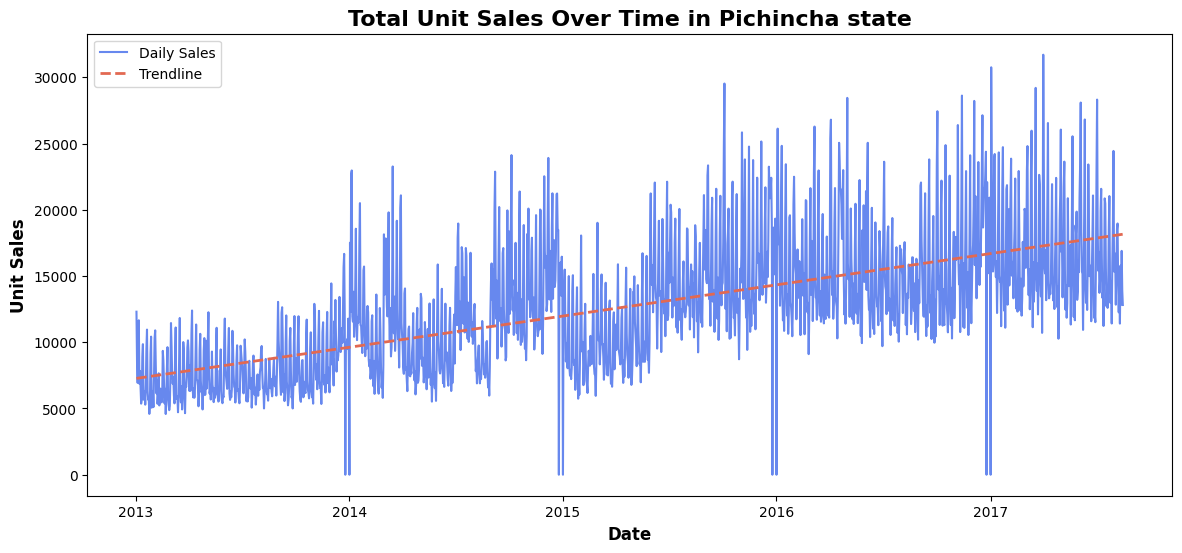

In [7]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Convert dates to numerical format for plotting
x_data = mdates.date2num(sales_by_date.index)
y_data = sales_by_date.values

# Calculate the trendline (linear regression)
z = np.polyfit(x_data, y_data, 1)
p = np.poly1d(z)

# Setting up the plot
plt.figure(figsize=(14, 6))
plt.plot(sales_by_date.index, sales_by_date.values, color=color_cold, alpha=1, label='Daily Sales')
plt.plot(sales_by_date.index, p(x_data), color=color_hot, linestyle='--', linewidth=2, label='Trendline')

# Add titles, labels, and legend
plt.title('Total Unit Sales Over Time in Pichincha state', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Unit Sales', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Save the figure
plt.savefig('../visualizations/pichincha-sales-trend.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

Observing total unit sales over time in the Pichincha state, I noticed the following:

- **Steady Growth:** There is a clear upward trend with sales consistently sloping upwards. This shows the business is expanding, and I can look closer at this growth later to see if it’s driven by new store openings or just higher customer demand.
- **Planned Closures:** The sudden drops to near-zero every year likely indicate days when stores are closed for holidays. I’ll need to account for these as "expected zeros" in my forecasting models so the AI doesn't get confused by these artificial dips.
- **Predictable Cycles:** I can see a "heartbeat" in the data from weekly shopping cycles, along with a massive spike every year during Q4. Knowing that the end of the year is always the busiest will be key for helping the business optimize their staffing and stock levels.

#### 5.2 Seasonality Analysis: Pichincha Region (2013-2017)

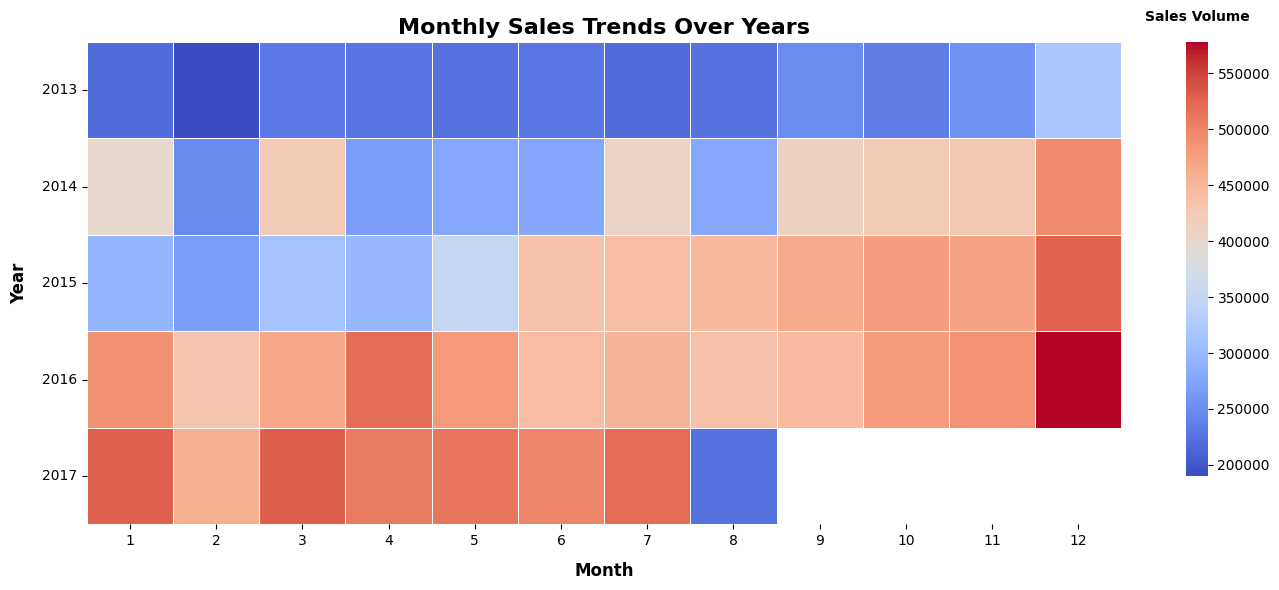

In [9]:
# Create a temporary copy to extract time features for visualization only
df_temp = df_train.copy()
df_temp['year'] = df_temp['date'].dt.year
df_temp['month'] = df_temp['date'].dt.month

# Aggregating sales by year and month
sales_by_month = df_temp.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Setting up the heatmap of sales by month and year
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    sales_by_month, 
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"anchor": (0, 1.0), "shrink": 0.9}
)

# Add titles and labels
plt.title('Monthly Sales Trends Over Years', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Year', fontsize=12, fontweight='bold', labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)

# Colorbar customization
cbar = ax.collections[0].colorbar
cbar.ax.set_title('Sales Volume', fontweight='bold', fontsize=10, pad=15)
cbar.ax.tick_params(labelsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('../visualizations/pichincha-seasonality-analysis.png', dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()

By looking at the sales data as a heatmap, I can really see the "rhythm" of the business and how it changes throughout the year:

- **The December Peak:** It is obvious that December is the "hottest" month every single year, which makes sense since that’s when everyone is out shopping for the holidays. With this insight, inventory, staff and promotions can be increased over this period.
- **The Post-Holiday Slump:** Right after that December rush, sales noticeably cool down in January and February. It looks like people really tighten their belts and spend less at the start of the year after their big holiday splurges.
- **Yearly Progress:** Looking from top to bottom (2013 to 2017), the map gets "warmer" overall. This confirms what I saw in the line chart: the business is definitely getting bigger and busier as the years go by.
- **The August 2017 Mystery:** There’s a sudden "cold" blue patch in August 2017 that sticks out like a sore thumb. Before attributing this to unusually low sales, it is worth investigating whether the dataset is complete. It would be safer to exclude this month from the forecasting models until futher investigation has been done so as not to skew the results.

### 6 - Examining the Impact of Holidays

In [10]:
# Preview holidays dataframe
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
# Confirm date column is in datetime format
df_holidays.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [12]:
# Check the date range covered by the holidays dataset
print(
    "Holiday file covers:",
    df_holidays['date'].dt.date.min(), "→",
    df_holidays['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


In [13]:
# Join holidays and daily sales data
df_train_holidays = pd.merge(
    df_train,
    df_holidays[['date', 'type']],
    on='date',
    how='left'
)

# Preview joined dataframe
df_train_holidays.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,type
0,2013-05-09,5329375,1,96995,1.0,False,NaN
1,2013-05-10,0,1,96995,0.0,False,NaN
2,2013-05-11,0,1,96995,0.0,False,Additional
3,2013-05-12,0,1,96995,0.0,False,Holiday
4,2013-05-12,0,1,96995,0.0,False,Event


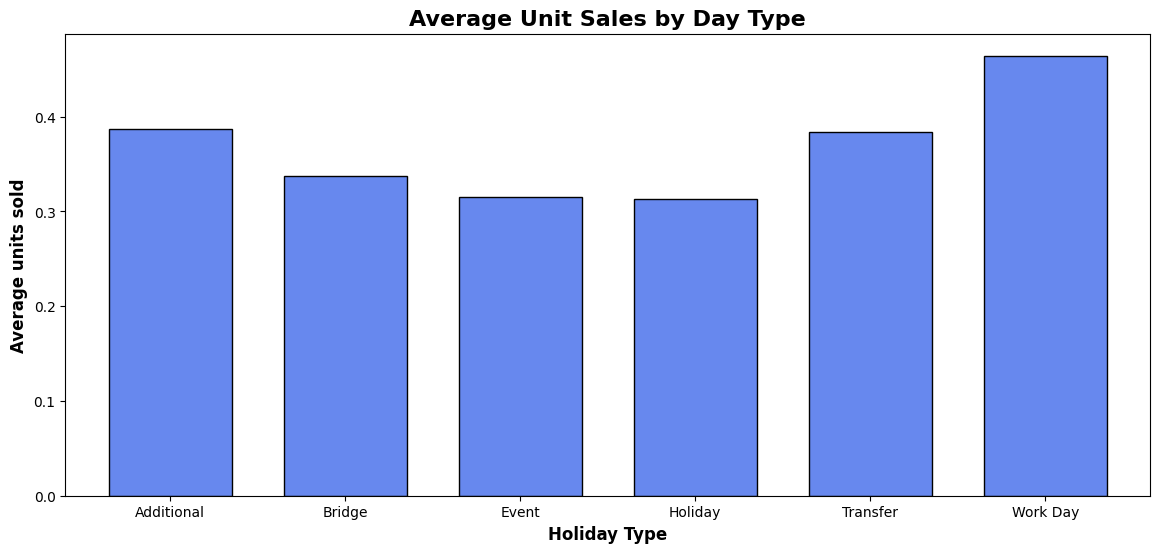

In [14]:
# Compare average sales for each holiday type
holiday_sales = df_train_holidays.groupby('type')['unit_sales'].mean()

# Create bar chart with title and labels
holiday_sales.plot(kind='bar', figsize=(14, 6), color=color_cold, edgecolor='black', width=0.7)
plt.title('Average Unit Sales by Day Type', fontsize=16, weight='bold')
plt.xlabel('Holiday Type', fontsize=12, fontweight='bold')
plt.ylabel('Average units sold', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10, rotation=0)

# Save the figure
plt.savefig('../visualizations/pichincha-holiday-sales.png', dpi=300, bbox_inches='tight')

# Display the bar plot
plt.show()

It looks like normal work days and additional shopping days are the big winners for sales volume, probably because people are just sticking to their usual routines. Transfer days also perform surprisingly well, though they’re a bit trickier to plan for because the shopping surge can happen on either the original holiday or the day it was moved to. Meanwhile, actual holidays and bridge days tend to see a dip, likely because people are traveling or stores are closing early, so I should be more conservative with my expectations for those dates.

### 7 - Analyzing Perishable Items

In [15]:
# Preview items dataframe
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,False
1,99197,GROCERY I,1067,False
2,103501,CLEANING,3008,False
3,103520,GROCERY I,1028,False
4,103665,BREAD/BAKERY,2712,True


In [16]:
# Confirm items data types
df_items.dtypes

item_nbr       int32
family        object
class          int32
perishable      bool
dtype: object

In [17]:
# Join daily sales data with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')

# Preview joined dataframe
df_train_items.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
0,2013-05-09,5329375,1,96995,1.0,False,GROCERY I,1093,False
1,2013-05-10,0,1,96995,0.0,False,GROCERY I,1093,False
2,2013-05-11,0,1,96995,0.0,False,GROCERY I,1093,False
3,2013-05-12,0,1,96995,0.0,False,GROCERY I,1093,False
4,2013-05-13,0,1,96995,0.0,False,GROCERY I,1093,False


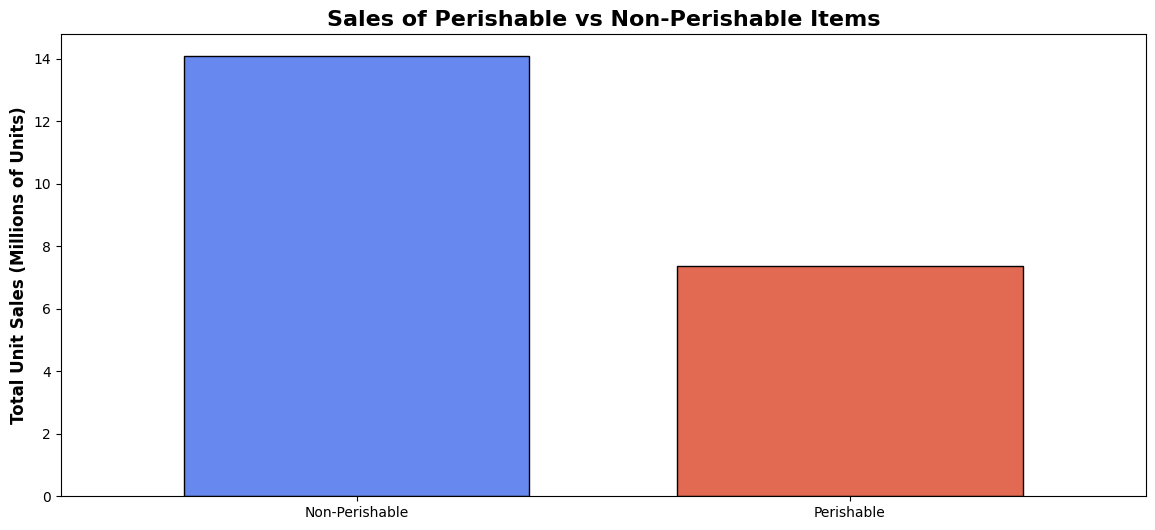

In [18]:
# Aggregating sales by perishable and non-perishable items
# Converted to millions for better readability
perishable_sales = (df_train_items.groupby('perishable')['unit_sales'].sum()) / 1_000_000

# Create bar chart with title and labels
perishable_sales.plot(kind='bar', figsize=(14, 6), color=[color_cold, color_hot], edgecolor='black', width=0.7)
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16, weight='bold')
plt.ylabel('Total Unit Sales (Millions of Units)', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.xticks(
    ticks=[0, 1], 
    labels=['Non-Perishable', 'Perishable'], 
    fontsize=10, 
    rotation=0
)
plt.yticks(fontsize=10)

# Save the figure
plt.savefig('../visualizations/pichincha-perishables.png', dpi=300, bbox_inches='tight')

# Display the bar plot
plt.show()

Looking at the split between these two categories, it’s clear that non-perishables are the real volume drivers for the business, making up about 65% of total sales. This makes sense because these are shelf-stable items like canned goods and cleaning supplies that stores and customers can stock up on in bulk without worrying about them going bad. Perishables, on the other hand, have a much shorter shelf life and often require refrigeration. Stores may limit perishable inventory to save on costs and reduce waste, while customers buy smaller quantities more frequently.

Considerations to keep in mind for forecasting:

- **Precision is critical:** The forecast for perishables needs to be extremely accurate to avoid spoilage.
- **Stock Balance:** The right balance between non-perishables and perishables needs to be maintained to keep customers coming back for fresh goods.
- **Promotion Opportunities:** Tracking expiration dates opens up a marketing opportunity to push near-expiry perishables through targeted promotions."

### 8 - Analyzing the Impact of Oil Prices

In [19]:
# Preview oil dataframe
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [20]:
# Confirm date column is in datetime format
df_oil.dtypes

date          datetime64[ns]
dcoilwtico           float64
dtype: object

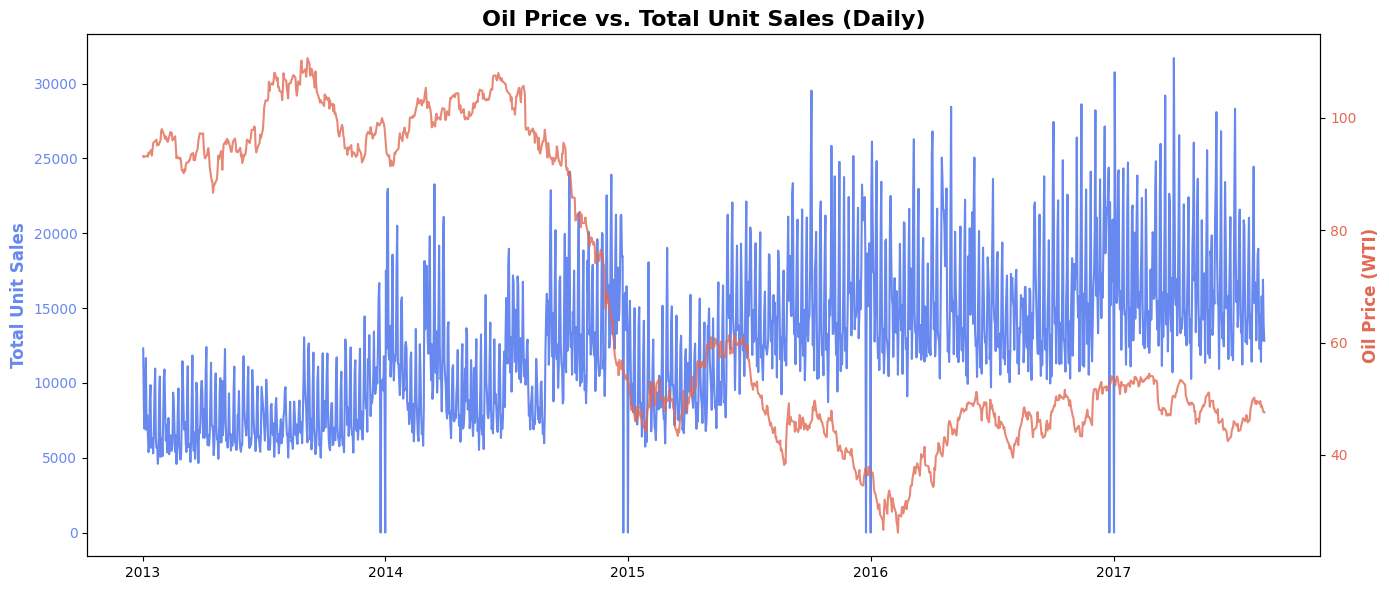

In [21]:
# Aggregate sales to daily total
daily_sales = (
    df_train
    .groupby('date', as_index=False)['unit_sales']
    .sum()
)

# Aggregate oil prices to daily average
daily_oil = (
    df_oil
    .groupby('date', as_index=False)['dcoilwtico']
    .mean()
)

# Merge on date
daily_sales_oil = daily_sales.merge(daily_oil, on='date', how='left')

# Interpolate missing oil prices and create smoothed sales columns
daily_sales_oil['dcoilwtico'] = daily_sales_oil['dcoilwtico'].interpolate()
daily_sales_oil['sales_smooth_m'] = daily_sales_oil['unit_sales'].rolling(window=30).mean()

# Set-up plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot unit sales on primary y-axis
ax1.plot(daily_sales_oil['date'], daily_sales_oil['unit_sales'], color=color_cold, label='Unit Sales')
ax1.set_ylabel('Total Unit Sales', color=color_cold, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_cold)

# Plot oil prices on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(daily_sales_oil['date'], daily_sales_oil['dcoilwtico'], color=color_hot, label='Oil Price', alpha=0.8)
ax2.set_ylabel('Oil Price (WTI)', color=color_hot, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_hot)

# Set plot title, layout and show
plt.title('Oil Price vs. Total Unit Sales (Daily)', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure
plt.savefig('../visualizations/pichincha-oil-price-impact.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

While the dual-axis chart shows that unit sales continued to climb even as oil prices collapsed in late 2014, this long-term divergence suggests the two variables are largely separated in the context of grocery demand. There is no immediate "mirrored" reaction to price shocks, implying that fuel costs aren't a direct driver of store-level consumer behavior. However, to ensure that subtle, short-term dependencies aren't being masked by these massive multi-year trends, I will now implement a rolling Pearson correlation. This targeted check will confirm if any temporary "coupling" occurred during specific economic shifts or if oil is truly a incidental variable.

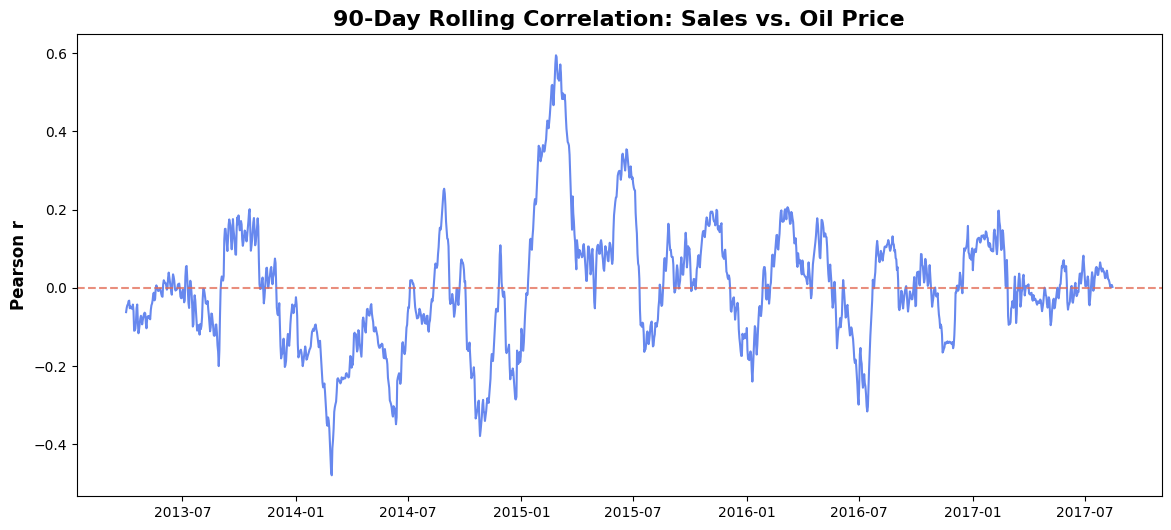

In [ ]:
# Calculate a 90-day rolling correlation
rolling_corr = daily_sales_oil['unit_sales'].rolling(window=90).corr(daily_sales_oil['dcoilwtico'])

# Plot the rolling correlation
plt.figure(figsize=(14, 6))
plt.plot(daily_sales_oil['date'], rolling_corr, color=color_cold)
plt.axhline(0, color=color_hot, linestyle='--', alpha=0.75)

# Add titles and labels
plt.title('90-Day Rolling Correlation: Sales vs. Oil Price', fontsize=16, fontweight='bold')
plt.ylabel('Pearson r', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the figure
plt.savefig('../visualizations/pichincha-oil-price-correlation.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

My analysis confirms that oil price is a non-predictive variable for this dataset. While the 2014 price collapse occurred alongside a steady rise in unit sales, the 90-day rolling correlation remained centered around zero for nearly the entire five-year period. With significant correlation spikes occurring sporadically, including this feature would likely introduce noise and lead the model to overfit on rare, coincidental fluctuations. Consequently, I am prioritizing feature engineering on internal drivers like promotions and calendar effects, which provide a significantly stronger and more consistent signal for demand.

### 9 - Time-Series Diagnostics

Understanding how daily sales relate to their own past values helps decide which forecasting approaches are suitable. This section looks at autocorrelation patterns, rolling statistics, the ADF test, and an STL decomposition to assess trend and seasonality strength.

#### 9.1 Autocorrelation Analysis

To identify repeating patterns and potential seasonality, I am using an **Autocorrelation Plot**. This visualization measures the relationship between the current day's sales and previous days (lags).

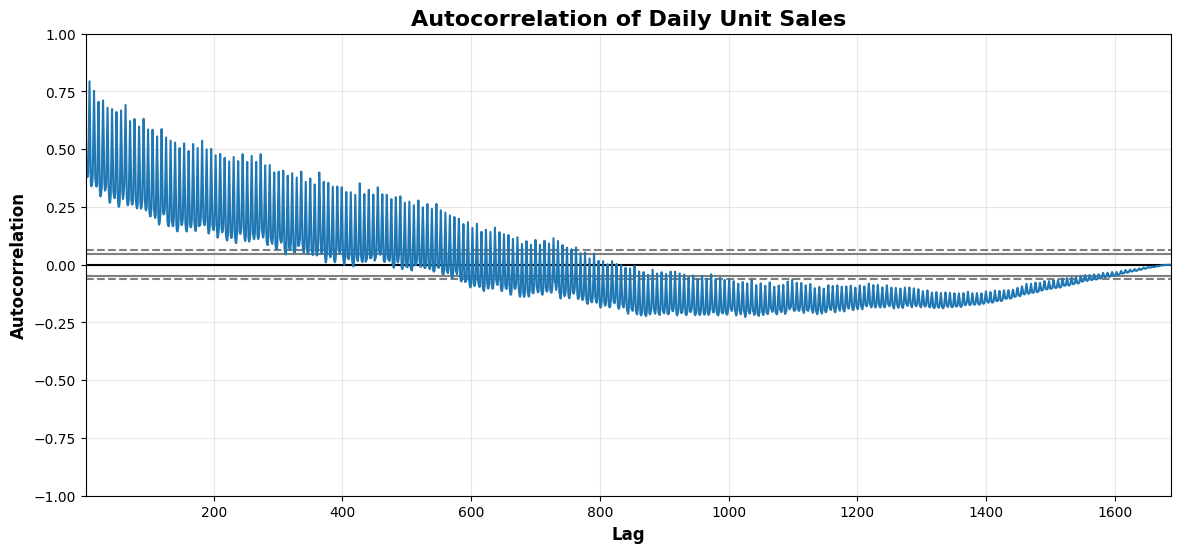

In [ ]:
# Aggregate total sales
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot autocorrelation with pandas built-in confidence intervals
plt.figure(figsize=(14, 6))
autocorrelation_plot(sales_by_date)

# Add titles and labels
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16, fontweight='bold')
plt.xlabel('Lag', fontsize=12, fontweight='bold')
plt.ylabel('Autocorrelation', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, alpha=0.3)

# Save the figure
plt.savefig('../visualizations/pichincha-autocorrelation.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

By plotting the autocorrelation of the daily sales, I discovered that sales have a high autocorrelation, especially in the short term. The correlation starts very high and gradually decreases, but I also noticed significant peaks at 7-day intervals. This confirms that past unit sales are highly predictive and that lag-based features, particularly a 7-day lag, will be crucial for building my forecasting models.

#### 9.2 Stationarity Check

In Section 5, my initial visualizations of total unit sales over time already pointed toward definite growth trends and seasonal cycles. These characteristics strongly suggest that the data is non-stationary. To confirm this more formally, I will now look at the **rolling mean** and **rolling standard deviation**. This allows me to see if the average level of sales and the overall volatility remain constant or shift as time progresses.

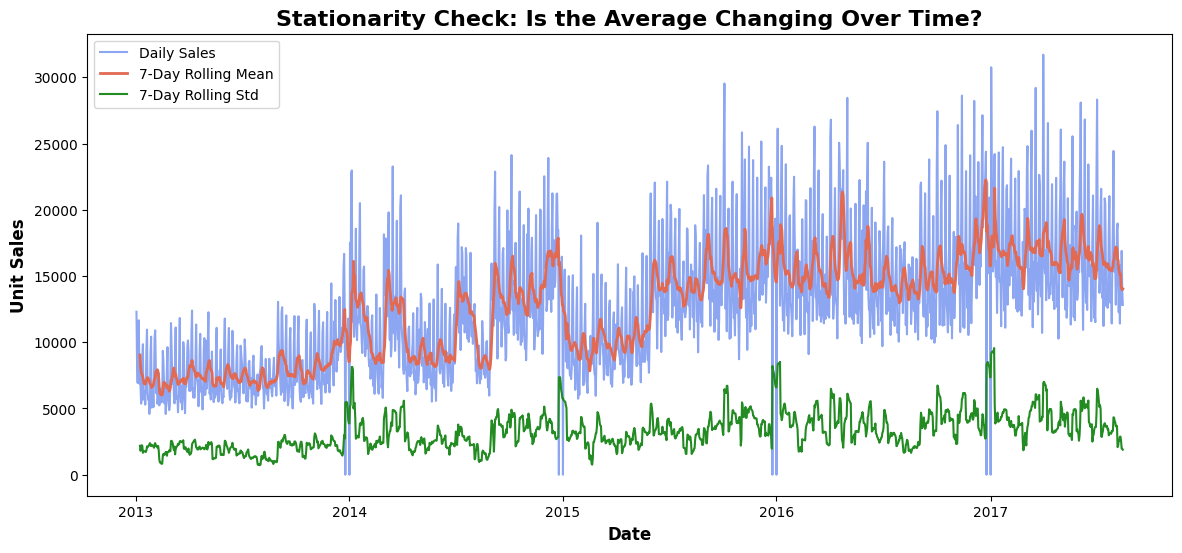

In [29]:
# Calculate a 7-day rolling mean and standard deviation (volatility)
rolling_mean = sales_by_date.rolling(window=7).mean()
rolling_std = sales_by_date.rolling(window=7).std()

# Create the plot
plt.figure(figsize=(14, 6))

# Plot the daily sales data
plt.plot(sales_by_date, label='Daily Sales', color=color_cold, alpha=0.75)

# Plot the rolling mean to show the trend
plt.plot(rolling_mean, label='7-Day Rolling Mean', color=color_hot, linewidth=2)

# Plot the rolling standard deviation to see if the volatility is changing
plt.plot(rolling_std, label='7-Day Rolling Std', color='forestgreen')

# 3. Add titles and labels
plt.title('Stationarity Check: Is the Average Changing Over Time?', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Unit Sales', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left', fontsize=10)

# Save the visualization
plt.savefig('../visualizations/pichincha-stationarity-check.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

I used a 7-day rolling window to inspect the stationarity of the sales data. By looking at the **Rolling Mean (red line)**, I can see a clear upward trend from 2013 through 2017. Interestingly, the **Rolling Standard Deviation (green line)** remains relatively stable compared to the mean. This tells me that while the total volume of sales is growing, the day-to-day volatility isn't "exploding" at the same rate.

Because the average level of sales changes over time rather than staying flat, I have confirmed that this series is **non-stationary**. This finding justifies the use of models like **SARIMA**, which can handle non-stationary data through differencing, and **XGBoost**, which can capture complex trends through gradient boosting.

#### 9.3 Augmented Dickey-Fuller (ADF) Test

To move beyond my visual observations, I’m using the **Augmented Dickey-Fuller (ADF)** test to provide statistical proof of whether my sales data is stationary or if the trends I've seen are significant enough to require specialized modeling.

In [31]:
# Apply Augmented Dickey-Fuller test
result = adfuller(sales_by_date)

print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}\n")

# Interpreting the result based on the 0.05 significance threshold
if result[1] > 0.05:
    print("Conclusion: The p-value is > 0.05. I fail to reject the null hypothesis. The series is NON-STATIONARY.")
else:
    print("Conclusion: The series is stationary.")

ADF Statistic: -2.8126
p-value: 0.0565

Conclusion: The p-value is > 0.05. I fail to reject the null hypothesis. The series is NON-STATIONARY.


Since the p-value of 0.056 exceeds the standard 0.05 threshold, I fail to reject the null hypothesis, confirming that the evidence is not strong enough to consider the series stationary. This statistical result validates my earlier visual observations of an upward growth trend and clear seasonal cycles, proving that I must account for **non-stationarity** in my forecasting models.

#### 9.4 STL Decomposition

I am performing an **STL Decomposition** to mathematically separate my sales data into three distinct components: the long-term Trend, the repeating Seasonal pulse, and the Residual noise. This "dissection" allows me to see exactly how much each factor contributes to the overall sales volume.

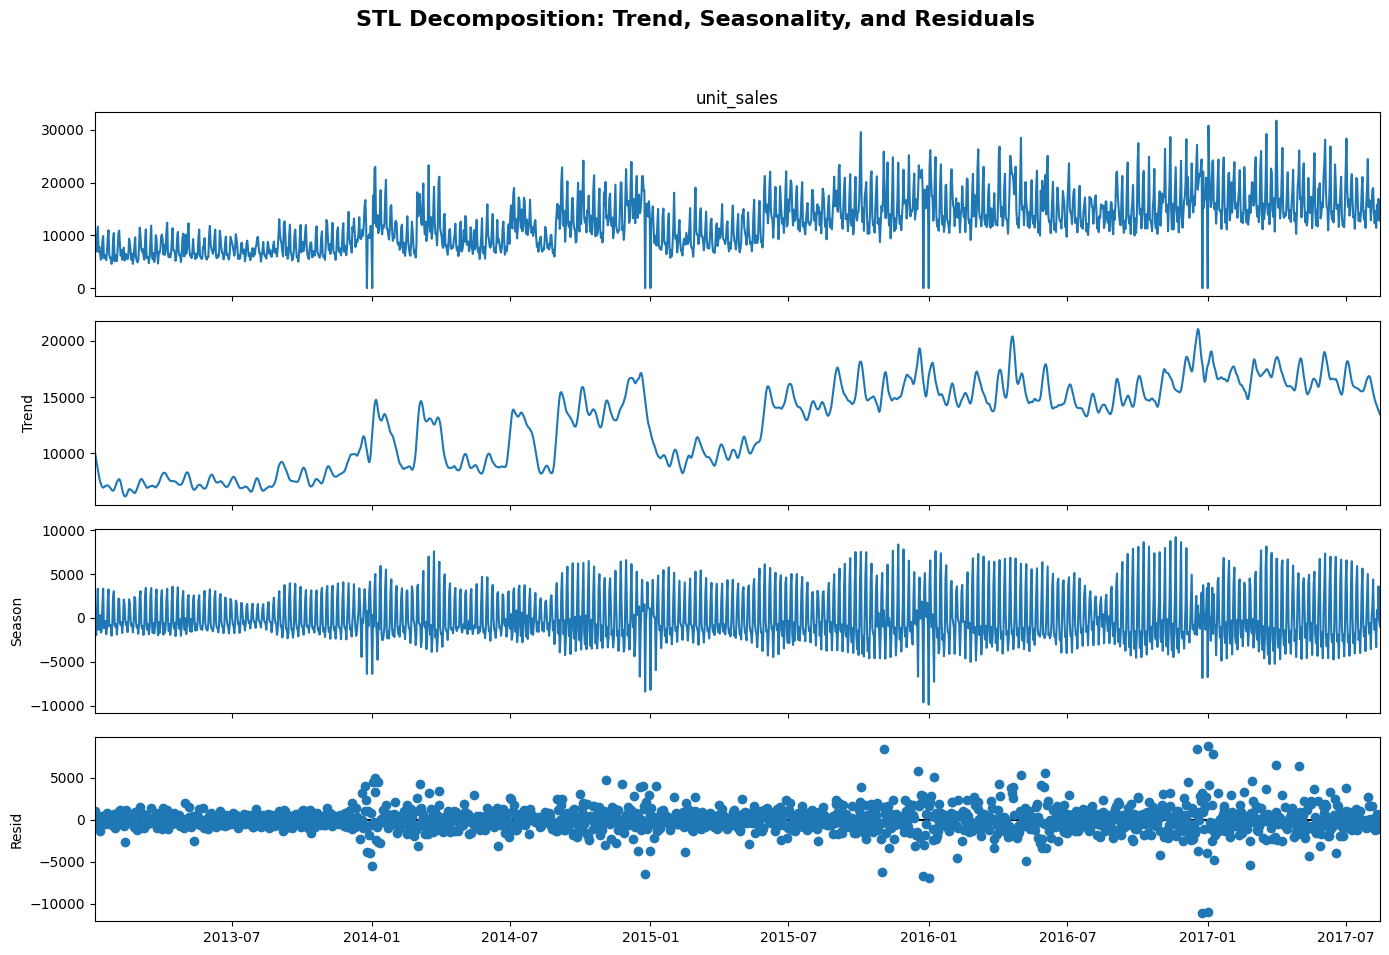

In [34]:
# Using a period of 7 to match weekly shopping cycle in autocorrelation plot
stl = STL(sales_by_date, period=7)
res = stl.fit()

# Plotting the decomposition
fig = res.plot()
fig.set_size_inches(14, 10)
plt.suptitle('STL Decomposition: Trend, Seasonality, and Residuals', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the visualization
plt.savefig('../visualizations/pichincha-stl-decomposition.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

By decomposing the series, I have isolated a dominant growth trend and a highly rhythmic seasonal pattern, both of which are central to the sales behavior. The presence of specific spikes in the residuals confirms that while the data is structured, external shocks like holidays still play a significant role and will require robust feature engineering in the modeling phase.

#### 9.5 Strength of Components

In [35]:
# Calculate strength of trend and seasonality based on Hyndman’s definition
trend_strength = max(0, 1 - (np.var(res.resid) / np.var(res.trend + res.resid)))
seasonal_strength = max(0, 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid)))

print(f"Strength of Trend: {trend_strength:.4f}")
print(f"Strength of Seasonality: {seasonal_strength:.4f}")

Strength of Trend: 0.8737
Strength of Seasonality: 0.8098


With a **Trend Strength of 0.87** and **Seasonality Strength of 0.81**, it is clear that the data is non-stationary due to both trend and seasonality. This confirms that a model capable of capturing both temporal trends and weekly cycles, such as **SARIMA**, is the correct strategic choice for the next phase of the project.